In [1]:
import matplotlib.pyplot as plt
import sys
import os
# Add the src directory to the path
sys.path.insert(0, os.path.abspath('../src'))
import dataloader
import pandas as pd
import numpy as np

%matplotlib widget
plot_flag = False

# Test of synchronization between the ET and EEG data

- Experiments were conducted for dyads  "W003" "W020" "W030" "W036" 
- For alignment test we use the comparison of blinks detecte by ET and the signal from Fp1 EEG channel. 
- To have a smooth EEG signal filter it bandpass between 1 and 10 Hz.

**The estimated delay is ~0.2s** which needs to be subtracted from time axis of ET signals.

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown widget for dyad selection
dyad_selector = widgets.Dropdown(
    options=['W003', 'W020', 'W030', 'W036'],
    value='W036',
    description='Dyad ID:',
    disabled=False,
)

display(dyad_selector)

Dropdown(description='Dyad ID:', index=3, options=('W003', 'W020', 'W030', 'W036'), value='W036')

In [3]:
# creates a DataLoader class object that creates a structure described in the docs folder (data_structure_spec.md) from raw data

dyad_id = dyad_selector.value
lowcut=1.0
highcut=10.0
multimodal_data = dataloader.create_multimodal_data(data_base_path = "../data", dyad_id = dyad_id, load_eeg=True, load_et=True, plot_flag=plot_flag, lowcut=lowcut, highcut=highcut)

Detected events: [{'name': 'Brave', 'start': 261.4638671875, 'duration': 59.31640625}, {'name': 'Peppa', 'start': 330.9794921875, 'duration': 59.6142578125}, {'name': 'Incredibles', 'start': 400.7939453125, 'duration': 59.212890625}, {'name': 'Talk_1', 'start': 554.76171875, 'duration': 181.056640625}, {'name': 'Talk_2', 'start': 792.0615234375, 'duration': 181.0576171875}]
Applying fir filters to EEG data.
Reseting the EEG time to the start of Brave
ET time range: 230.12s to 456.63s
Reseting the ET time to the start of m1


Select caregiver or child data and zoom in to make sure the `delta` is OK.

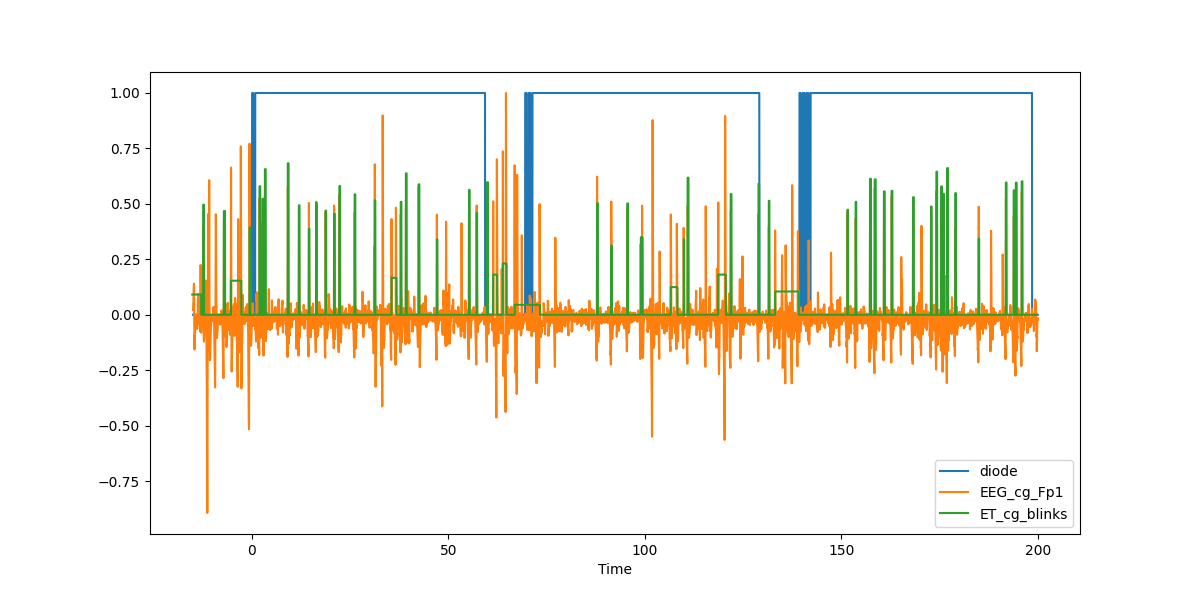

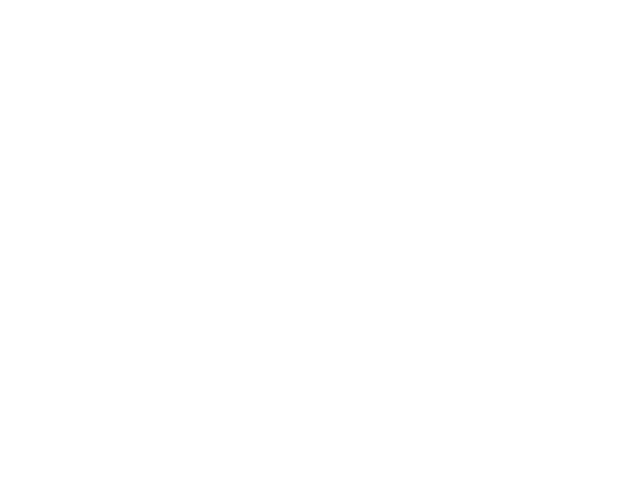

In [4]:
delta = 0.2  # to align ET with EEG (seconds): subtract from time axis of ET signals
who = 'cg' # choose 'cg' or 'ch' for caregiver or child data
data_selected = multimodal_data.data[(multimodal_data.data.time>-15)&(multimodal_data.data.time<200)]

plt.figure()
fig, ax = plt.subplots(figsize=(12, 6),sharex=True, sharey=False,nrows=1)

ax.plot(data_selected['time'], data_selected['diode'], linestyle='-', label='diode')
ax.plot(data_selected['time'], (data_selected[f'EEG_{who}_Fp1'])/np.max(data_selected[f'EEG_{who}_Fp1']), linestyle='-', label=f'EEG_{who}_Fp1')
ax.plot(data_selected['time']-delta, data_selected[f'ET_{who}_blinks'], linestyle='-', label=f'ET_{who}_blinks')

ax.legend()
plt.xlabel('Time')
plt.show()

Event mapping: {None: 0, 'm1': 1, 'm2': 2, 'm3': 3}
Event mapping for events: {None: 0, 'Brave': 1, 'Peppa': 2, 'Incredibles': 3, 'Talk_1': 4, 'Talk_2': 5}


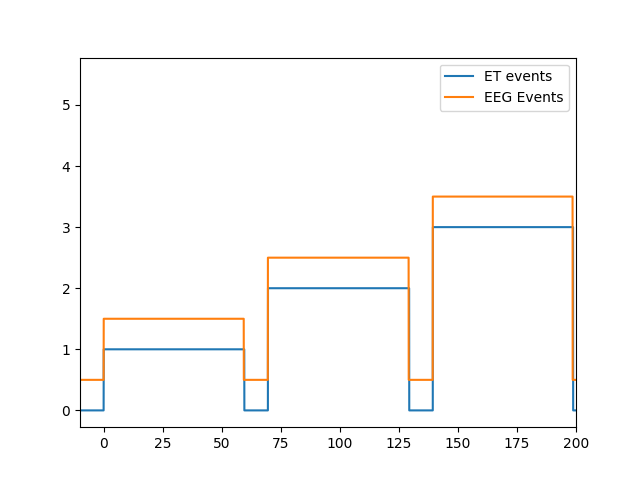

In [5]:
event_mapping = {event: idx for idx, event in enumerate(multimodal_data.data['ET_event'].unique())}
print("Event mapping:", event_mapping)

# Map ET_event to integer values
multimodal_data.data['event_num_ET'] = multimodal_data.data['ET_event'].map(event_mapping)

# create a mapping from unique events values to integers
event_mapping_events = {event: idx for idx, event in enumerate(multimodal_data.data['events'].unique())}
print("Event mapping for events:", event_mapping_events)

multimodal_data.data['event_num_events'] = multimodal_data.data['events'].map(event_mapping_events)

plt.figure()
plt.plot(multimodal_data.data['time'], multimodal_data.data['event_num_ET'], label='ET events')
plt.plot(multimodal_data.data['time'], multimodal_data.data['event_num_events']+0.5, label='EEG Events')
plt.legend()
plt.xlim(-10,200)
plt.show()

Test if blinks are aligned with x,y?

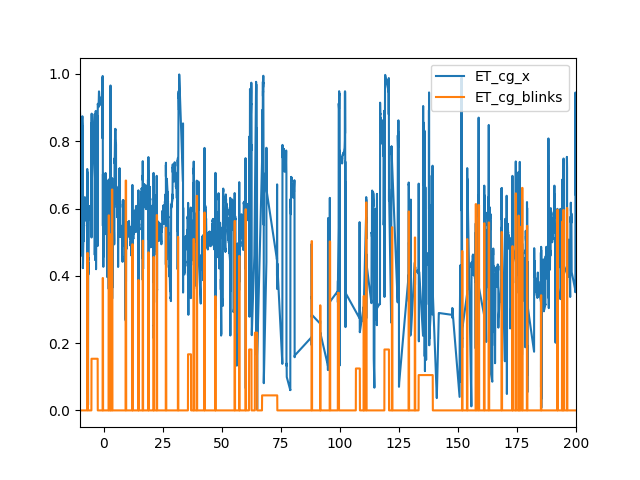

In [6]:
plt.figure()
plt.plot(multimodal_data.data['time'], multimodal_data.data[f'ET_{who}_x'], label=f'ET_{who}_x')
plt.plot(multimodal_data.data['time'], multimodal_data.data[f'ET_{who}_blinks'], label=f'ET_{who}_blinks')
plt.legend()
plt.xlim(-10,200)
plt.show()

In [7]:
multimodal_data.data.columns

Index(['time_idx', 'EEG_ch_Fp1', 'EEG_ch_Fp2', 'EEG_ch_F7', 'EEG_ch_F3',
       'EEG_ch_Fz', 'EEG_ch_F4', 'EEG_ch_F8', 'EEG_ch_M1', 'EEG_ch_T3',
       'EEG_ch_C3', 'EEG_ch_Cz', 'EEG_ch_C4', 'EEG_ch_T4', 'EEG_ch_M2',
       'EEG_ch_T5', 'EEG_ch_P3', 'EEG_ch_Pz', 'EEG_ch_P4', 'EEG_ch_T6',
       'EEG_ch_O1', 'EEG_ch_O2', 'EEG_cg_Fp1', 'EEG_cg_Fp2', 'EEG_cg_F7',
       'EEG_cg_F3', 'EEG_cg_Fz', 'EEG_cg_F4', 'EEG_cg_F8', 'EEG_cg_M1',
       'EEG_cg_T3', 'EEG_cg_C3', 'EEG_cg_Cz', 'EEG_cg_C4', 'EEG_cg_T4',
       'EEG_cg_M2', 'EEG_cg_T5', 'EEG_cg_P3', 'EEG_cg_Pz', 'EEG_cg_P4',
       'EEG_cg_T6', 'EEG_cg_O1', 'EEG_cg_O2', 'events', 'diode', 'ECG_ch',
       'ECG_cg', 'ET_event', 'ET_ch_x', 'ET_ch_y', 'ET_ch_diameter3d',
       'ET_ch_blinks', 'ET_cg_x', 'ET_cg_y', 'ET_cg_diameter3d',
       'ET_cg_blinks', 'time', 'event_num_ET', 'event_num_events'],
      dtype='object')